### 1D Burger's equation

$u_t + uu_{x} - (0.01/\pi)u_{xx}, x\in[-1, 1], t\in[0, 1]$

$u(0, x) = -\sin(\pi x),$

$u(t, -1)=u(t, 1)=0$

In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import autograd
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

import numpy as np

### Solve PDE with finite difference using py-pde 

In [2]:
import sys
sys.path.append('./py-pde/')

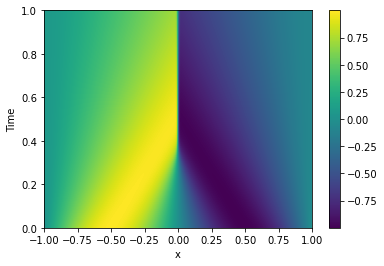

In [3]:
from pde import CartesianGrid, MemoryStorage, PDEBase, ScalarField, plot_kymograph, ExplicitSolver

class Burger1D(PDEBase):
    def __init__(self, bc):
        super(Burger1D, self).__init__()
        self.bc = bc
    def evolution_rate(self, u, t=0):
        assert u.grid.dim == 1
        u_x = u.gradient("natural")[0]
        return -u*u_x+(0.01/np.pi)*u.laplace("natural")
    
Nx = 1000
grid = CartesianGrid([[-1, 1]], [Nx], periodic=False)
u = ScalarField.from_expression(grid, "-sin(pi*x)")

storage = MemoryStorage()
eq = Burger1D(bc={"value": 0.0})
eq.solve(u, t_range=1, tracker=storage.tracker(0.01), dt=1e-4)

plot_kymograph(storage)

In [4]:
# reshape the output
xb = grid.axes_bounds[0]
x = np.linspace(*xb, grid.shape[0]+2)
t = np.array(storage.times)
x_mesh, t_mesh = np.meshgrid(x[1:-1], t)
fd_sol = torch.from_numpy(np.concatenate(storage.data)).float().reshape(-1, 1)
sol_grids = torch.from_numpy(np.concatenate([x_mesh.reshape(-1, 1), t_mesh.reshape(-1, 1)], axis=1)).float()

### Define a feedforward network

In [5]:
from collections import OrderedDict

class Dense(nn.Module):
    def __init__(self, activation, inputs, outputs):
        super(Dense, self).__init__()
        self.linear = nn.Linear(inputs, outputs)
        self.activation = activation
    
    def forward(self, x):
        return self.activation(self.linear(x))
    

def ffn(activation, n_hidden, n_nodes):
    layers = []
    for i in range(n_hidden+2):
        if i == 0:
            layers.append(('input', Dense(activation, 2, n_nodes)))
        elif i == n_hidden+1:
            layers.append(('output', nn.Linear(n_nodes, 1)))
        else:
            layers.append(('hidden_{}'.format(i), Dense(activation, n_nodes, n_nodes)))
        
    return nn.Sequential(OrderedDict(layers)).to(device)

### Define pde

In [9]:
# defining the PDE residue
def f(net, x, t):
    inputs = torch.cat([x, t], axis=1)
    u = net(inputs)
    u_t = torch.autograd.grad(u.sum(), t, create_graph=True)[0]
    u_x = torch.autograd.grad(u.sum(), x, create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x.sum(), x, create_graph=True)[0]
    return u_t + u*u_x - (0.01/np.pi)*u_xx

In [10]:
# The true initial and boundary value.
def u_init(net, x, t):
    return net(torch.cat([x, t], axis=1)) + torch.sin(np.pi*x)
def u_bc(net, x, t):
    return net(torch.cat([x, t], axis=1))

### Define loss function, optimizer and train

In [11]:
mse_loss = torch.nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters())

In [ ]:
# Set number of samples
N_init = 50
N_bc = 50
N_f = 5000

In [14]:
# Create samples from initial condition
x_init = (2.0*torch.rand((N_init, 1), requires_grad=True) - 1.0).to(device)
t_init = (torch.zeros((N_init, 1), requires_grad=True)).to(device)

# Create samples from boundary condition
t_bc = (torch.rand((N_bc, 1), requires_grad=True)).to(device)
x_bc = (torch.ones((N_bc, 1))).to(device)
x_bc[:int(N_bc/2)] = -1
x_bc.requires_grad = True

# Create data point for pde constraint
x_f = (2.0*torch.rand((N_f, 1), requires_grad=True) - 1.0).to(device)
t_f = (torch.rand((N_f, 1), requires_grad=True)).to(device)

max_epochs = 10000
errors = []
losses = []
for epoch in range(max_epochs):
    optimizer.zero_grad()
    
    
    # loss from boundary and initial condition
    mse_u = mse_loss(u_init(net, x_init, t_init), torch.zeros_like(t_init)) + \
    mse_loss(u_bc(net, x_bc, t_bc), torch.zeros_like(t_bc))
    
    # loss from PDE
    mse_f = mse_loss(f(net, x_f, t_f), torch.zeros_like(t_f))
    
    loss = mse_u + mse_f
    
    with autograd.no_grad():
        u = net(sol_grids)
        errors.append(mse_loss(u, fd_sol))
        losses.append(loss.item())
    
    loss.backward(retain_graph=True)
    optimizer.step()
    
    if epoch % 500 == 0:
        print('Epoch {}: loss is {}, error is {}'.format(epoch, loss, errors[-1]))

Epoch 0: loss is 0.5414950847625732, error is 0.4163767695426941
Epoch 500: loss is 0.1281881481409073, error is 0.09829118847846985
Epoch 1000: loss is 0.09405399858951569, error is 0.08856391161680222
Epoch 1500: loss is 0.0828879103064537, error is 0.08164326101541519
Epoch 2000: loss is 0.06754086911678314, error is 0.07341648638248444
Epoch 2500: loss is 0.05045754462480545, error is 0.05911223590373993
Epoch 3000: loss is 0.04501761868596077, error is 0.0586412288248539
Epoch 3500: loss is 0.04280664771795273, error is 0.05736029893159866
Epoch 4000: loss is 0.03374652564525604, error is 0.045430272817611694
Epoch 4500: loss is 0.018354522064328194, error is 0.037505678832530975
Epoch 5000: loss is 0.014857595786452293, error is 0.03576652333140373
Epoch 5500: loss is 0.01228907611221075, error is 0.03525349125266075
Epoch 6000: loss is 0.011000419966876507, error is 0.03479935601353645
Epoch 6500: loss is 0.009906312450766563, error is 0.03401270881295204
Epoch 7000: loss is 0.0

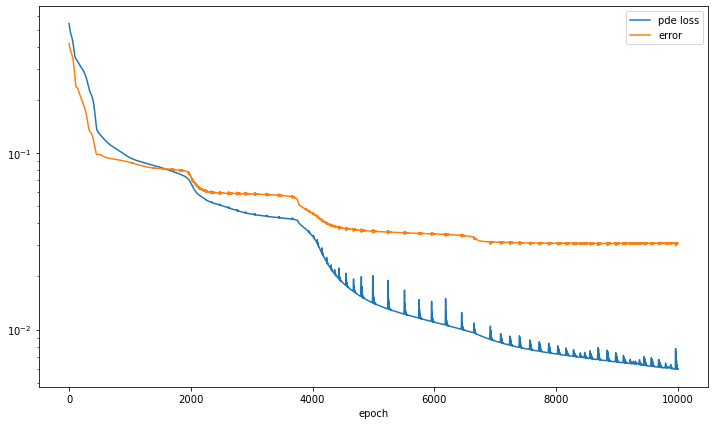

In [16]:
# Plot loss and error w.r.t finite difference solution
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 7))
ax.plot(losses)
ax.plot(errors)
ax.legend(['pde loss', 'error'])
ax.set_xlabel('epoch')
ax.set_yscale('log')